# 01: Onshore layout-to-LCOE

In this example, we will demonstrate `Ard`'s ability to run a layout-to-LCOE analysis and optimization.

We can start by loading what we need to run the problem.

In [1]:
from pathlib import Path  # optional, for nice path specifications

import pprint as pp  # optional, for nice printing
import numpy as np  # numerics library
import matplotlib.pyplot as plt  # plotting capabilities

import ard  # technically we only really need this
from ard.utils.io import load_yaml  # we grab a yaml loader here
from ard.api import set_up_ard_model  # the secret sauce
from ard.viz.layout import plot_layout  # a plotting tool!

import openmdao.api as om  # for N2 diagrams from the OpenMDAO backend

%matplotlib inline

numpy.ndarray size changed, may indicate binary incompatibility. Expected 16 from C header, got 96 from PyObject

This will do for now.
We can probably make it a bit cleaner for a later release.

Now, we can set up a case.
We do it a little verbosely so that our documentation system can grab it, you can generally just use relative paths.
We grab the file at `inputs/ard_system.yaml`, which describes the `Ard` system for this problem.
It references, in turn, the `inputs/windio.yaml` file, which is where we define the plant we want to optimize, and an initial setup for it.

In [ ]:
# load input
path_inputs = Path.cwd().absolute() / "inputs"
input_dict = load_yaml(path_inputs / "ard_system.yaml")

# create and setup system
prob = set_up_ard_model(input_dict=input_dict, root_data_path=path_inputs)

floris.floris_model.FlorisModel WARNING turbine_type has been changed without specifying a new reference_wind_height. reference_wind_height remains 90.00 m. Consider calling `FlorisModel.assign_hub_height_to_ref_height` to update the reference wind height to the turbine hub height.


Adding top_level
Adding layout2aep
Adding layout to layout2aep
Adding aepFLORIS to layout2aep
	Activating approximate totals on layout2aep
Adding boundary
Adding landuse
Adding collection
Adding spacing_constraint
Adding tcc
Adding landbosse
Adding opex
Adding financese


Here, you should see each of the groups or components described as they are added to the `Ard` model and, occasionally, some options being turned on on them, like semi-total finite differencing on groups.

Next is some code you can flip on to use the [N2 diagram vizualization tools from the backend toolset, OpenMDAO, that we use](https://openmdao.org/newdocs/versions/latest/features/model_visualization/n2_basics/n2_basics.html).
This can be a really handy debugging tool, if somewhat tricky to use; turned on it will show a comprehensive view of the system in terms of its components, variables, and connections, although we leave it off for now.

In [3]:
if False:
    # visualize model
    om.n2(prob)

Now, we do a one-shot analysis.
The one-shot analysis will run a wind farm as specified in `inputs/windio.yaml` and with the models specified in `inputs/ard_system.yaml`, then dump the outputs.

In [4]:
# run the model
prob.run_model()

# collapse the test result data
test_data = {
    "AEP_val": float(prob.get_val("AEP_farm", units="GW*h")[0]),
    "CapEx_val": float(prob.get_val("tcc.tcc", units="MUSD")[0]),
    "BOS_val": float(prob.get_val("landbosse.total_capex", units="MUSD")[0]),
    "OpEx_val": float(prob.get_val("opex.opex", units="MUSD/yr")[0]),
    "LCOE_val": float(prob.get_val("financese.lcoe", units="USD/MW/h")[0]),
    "area_tight": float(prob.get_val("landuse.area_tight", units="km**2")[0]),
    "coll_length": float(prob.get_val("collection.total_length_cables", units="km")[0]),
    "turbine_spacing": float(
        np.min(prob.get_val("spacing_constraint.turbine_spacing", units="km"))
    ),
}

print("\n\nRESULTS:\n")
pp.pprint(test_data)
print("\n\n")

/Users/cfrontin/miniforge3/envs/ard-dev-env/lib/python3.12/site-packages/openmdao/recorders/sqlite_recorder.py:231: UserWarning:The existing case recorder file, ard_prob_out/problem_out/cases.sql, is being overwritten.
invalid value encountered in divideRuntimeWarning: /Users/cfrontin/miniforge3/envs/ard-dev-env/lib/python3.12/site-packages/floris/core/wake_deflection/gauss.py:163
invalid value encountered in divideRuntimeWarning: /Users/cfrontin/miniforge3/envs/ard-dev-env/lib/python3.12/site-packages/floris/core/wake_velocity/gauss.py:80
invalid value encountered in divide



RESULTS:

{'AEP_val': 405.9510682648514,
 'BOS_val': 41.68227106807093,
 'CapEx_val': 110.5,
 'LCOE_val': 37.328810082644566,
 'OpEx_val': 3.7400000000000007,
 'area_tight': 13.2496,
 'coll_length': 21.89865877023397,
 'turbine_spacing': 0.91}





Now, we can optimize the same problem!
The optimization details are set under the `analysis_options` header in `inputs/ard_system.yaml`.
Here, we use a four-dimensional rectilinear layout parameterization ($\theta$) as design variables, constrain the farm such that the turbines are in the boundaries and satisfactorily spaced, and then we optimize for LCOE.
$$
\begin{aligned}
\textrm{minimize}_\theta \quad & \mathrm{LCOE}(\theta, \ldots) \\
\textrm{subject to} \quad & f_{\mathrm{spacing}}(\theta, \ldots) < 0 \\
                          & f_{\mathrm{boundary}}(\theta, \ldots) < 0
\end{aligned}
$$

In [5]:
optimize = True  # set to False to skip optimization
if optimize:
    # run the optimization
    prob.run_driver()
    prob.cleanup()

    # collapse the test result data
    test_data = {
        "AEP_val": float(prob.get_val("AEP_farm", units="GW*h")[0]),
        "CapEx_val": float(prob.get_val("tcc.tcc", units="MUSD")[0]),
        "BOS_val": float(prob.get_val("landbosse.total_capex", units="MUSD")[0]),
        "OpEx_val": float(prob.get_val("opex.opex", units="MUSD/yr")[0]),
        "LCOE_val": float(prob.get_val("financese.lcoe", units="USD/MW/h")[0]),
        "area_tight": float(prob.get_val("landuse.area_tight", units="km**2")[0]),
        "coll_length": float(
            prob.get_val("collection.total_length_cables", units="km")[0]
        ),
        "turbine_spacing": float(
            np.min(prob.get_val("spacing_constraint.turbine_spacing", units="km"))
        ),
    }

    # clean up the recorder
    prob.cleanup()

    # print the results
    print("\n\nRESULTS (opt):\n")
    pp.pprint(test_data)
    print("\n\n")

Driver debug print for iter coord: rank0:ScipyOptimize_COBYLA|0
---------------------------------------------------------------
Design Vars
{'angle_orientation': array([0.]),
 'angle_skew': array([0.]),
 'spacing_primary': array([7.]),
 'spacing_secondary': array([7.])}



invalid value encountered in divideRuntimeWarning: /Users/cfrontin/miniforge3/envs/ard-dev-env/lib/python3.12/site-packages/floris/core/wake_deflection/gauss.py:163
invalid value encountered in divideRuntimeWarning: /Users/cfrontin/miniforge3/envs/ard-dev-env/lib/python3.12/site-packages/floris/core/wake_velocity/gauss.py:80
invalid value encountered in divide

Objectives
{'financese.lcoe': array([0.03732881])}

Driver debug print for iter coord: rank0:ScipyOptimize_COBYLA|1
---------------------------------------------------------------
Design Vars
{'angle_orientation': array([0.]),
 'angle_skew': array([0.]),
 'spacing_primary': array([7.]),
 'spacing_secondary': array([7.])}



invalid value encountered in divideRuntimeWarning: /Users/cfrontin/miniforge3/envs/ard-dev-env/lib/python3.12/site-packages/floris/core/wake_deflection/gauss.py:163
invalid value encountered in divideRuntimeWarning: /Users/cfrontin/miniforge3/envs/ard-dev-env/lib/python3.12/site-packages/floris/core/wake_velocity/gauss.py:80
invalid value encountered in divide

Objectives
{'financese.lcoe': array([0.03732881])}

Driver debug print for iter coord: rank0:ScipyOptimize_COBYLA|2
---------------------------------------------------------------
Design Vars
{'angle_orientation': array([0.]),
 'angle_skew': array([0.]),
 'spacing_primary': array([9.]),
 'spacing_secondary': array([7.])}



invalid value encountered in divideRuntimeWarning: /Users/cfrontin/miniforge3/envs/ard-dev-env/lib/python3.12/site-packages/floris/core/wake_deflection/gauss.py:163
invalid value encountered in divideRuntimeWarning: /Users/cfrontin/miniforge3/envs/ard-dev-env/lib/python3.12/site-packages/floris/core/wake_velocity/gauss.py:80
invalid value encountered in divide

Objectives
{'financese.lcoe': array([0.03630168])}

Driver debug print for iter coord: rank0:ScipyOptimize_COBYLA|3
---------------------------------------------------------------
Design Vars
{'angle_orientation': array([0.]),
 'angle_skew': array([0.]),
 'spacing_primary': array([9.]),
 'spacing_secondary': array([9.])}



invalid value encountered in divideRuntimeWarning: /Users/cfrontin/miniforge3/envs/ard-dev-env/lib/python3.12/site-packages/floris/core/wake_deflection/gauss.py:163
invalid value encountered in divideRuntimeWarning: /Users/cfrontin/miniforge3/envs/ard-dev-env/lib/python3.12/site-packages/floris/core/wake_velocity/gauss.py:80
invalid value encountered in divide

Objectives
{'financese.lcoe': array([0.0362278])}

Driver debug print for iter coord: rank0:ScipyOptimize_COBYLA|4
---------------------------------------------------------------
Design Vars
{'angle_orientation': array([2.]),
 'angle_skew': array([0.]),
 'spacing_primary': array([9.]),
 'spacing_secondary': array([9.])}



invalid value encountered in divideRuntimeWarning: /Users/cfrontin/miniforge3/envs/ard-dev-env/lib/python3.12/site-packages/floris/core/wake_deflection/gauss.py:163
invalid value encountered in divideRuntimeWarning: /Users/cfrontin/miniforge3/envs/ard-dev-env/lib/python3.12/site-packages/floris/core/wake_velocity/gauss.py:80
invalid value encountered in divide

Objectives
{'financese.lcoe': array([0.03589558])}

Driver debug print for iter coord: rank0:ScipyOptimize_COBYLA|5
---------------------------------------------------------------
Design Vars
{'angle_orientation': array([2.]),
 'angle_skew': array([2.]),
 'spacing_primary': array([9.]),
 'spacing_secondary': array([9.])}



invalid value encountered in divideRuntimeWarning: /Users/cfrontin/miniforge3/envs/ard-dev-env/lib/python3.12/site-packages/floris/core/wake_deflection/gauss.py:163
invalid value encountered in divideRuntimeWarning: /Users/cfrontin/miniforge3/envs/ard-dev-env/lib/python3.12/site-packages/floris/core/wake_velocity/gauss.py:80
invalid value encountered in divide

Objectives
{'financese.lcoe': array([0.03576731])}

Driver debug print for iter coord: rank0:ScipyOptimize_COBYLA|6
---------------------------------------------------------------
Design Vars
{'angle_orientation': array([2.86507341]),
 'angle_skew': array([0.06342541]),
 'spacing_primary': array([9.88412296]),
 'spacing_secondary': array([7.42966507])}



invalid value encountered in divideRuntimeWarning: /Users/cfrontin/miniforge3/envs/ard-dev-env/lib/python3.12/site-packages/floris/core/wake_deflection/gauss.py:163
invalid value encountered in divideRuntimeWarning: /Users/cfrontin/miniforge3/envs/ard-dev-env/lib/python3.12/site-packages/floris/core/wake_velocity/gauss.py:80
invalid value encountered in divide

Objectives
{'financese.lcoe': array([0.03536135])}

Driver debug print for iter coord: rank0:ScipyOptimize_COBYLA|7
---------------------------------------------------------------
Design Vars
{'angle_orientation': array([6.22440279]),
 'angle_skew': array([1.28942792]),
 'spacing_primary': array([11.09600928]),
 'spacing_secondary': array([6.10937891])}



invalid value encountered in divideRuntimeWarning: /Users/cfrontin/miniforge3/envs/ard-dev-env/lib/python3.12/site-packages/floris/core/wake_deflection/gauss.py:163
invalid value encountered in divideRuntimeWarning: /Users/cfrontin/miniforge3/envs/ard-dev-env/lib/python3.12/site-packages/floris/core/wake_deflection/gauss.py:498
invalid value encountered in divideRuntimeWarning: /Users/cfrontin/miniforge3/envs/ard-dev-env/lib/python3.12/site-packages/floris/core/wake_velocity/gauss.py:80
invalid value encountered in divide

Objectives
{'financese.lcoe': array([0.03370838])}

Driver debug print for iter coord: rank0:ScipyOptimize_COBYLA|8
---------------------------------------------------------------
Design Vars
{'angle_orientation': array([12.81065072]),
 'angle_skew': array([5.41443477]),
 'spacing_primary': array([10.77869556]),
 'spacing_secondary': array([4.23722274])}



invalid value encountered in divideRuntimeWarning: /Users/cfrontin/miniforge3/envs/ard-dev-env/lib/python3.12/site-packages/floris/core/wake_deflection/gauss.py:163
invalid value encountered in divideRuntimeWarning: /Users/cfrontin/miniforge3/envs/ard-dev-env/lib/python3.12/site-packages/floris/core/wake_velocity/gauss.py:80
invalid value encountered in divide

Objectives
{'financese.lcoe': array([0.03370143])}

Driver debug print for iter coord: rank0:ScipyOptimize_COBYLA|9
---------------------------------------------------------------
Design Vars
{'angle_orientation': array([4.28310721]),
 'angle_skew': array([4.24611554]),
 'spacing_primary': array([11.15159215]),
 'spacing_secondary': array([4.24222055])}



invalid value encountered in divideRuntimeWarning: /Users/cfrontin/miniforge3/envs/ard-dev-env/lib/python3.12/site-packages/floris/core/wake_deflection/gauss.py:163
invalid value encountered in divideRuntimeWarning: /Users/cfrontin/miniforge3/envs/ard-dev-env/lib/python3.12/site-packages/floris/core/wake_velocity/gauss.py:80
invalid value encountered in divide

Objectives
{'financese.lcoe': array([0.03451831])}

Driver debug print for iter coord: rank0:ScipyOptimize_COBYLA|10
----------------------------------------------------------------
Design Vars
{'angle_orientation': array([6.00666884]),
 'angle_skew': array([1.33986207]),
 'spacing_primary': array([12.01188114]),
 'spacing_secondary': array([6.44288611])}



invalid value encountered in divideRuntimeWarning: /Users/cfrontin/miniforge3/envs/ard-dev-env/lib/python3.12/site-packages/floris/core/wake_deflection/gauss.py:163
invalid value encountered in divideRuntimeWarning: /Users/cfrontin/miniforge3/envs/ard-dev-env/lib/python3.12/site-packages/floris/core/wake_velocity/gauss.py:80
invalid value encountered in divide

Objectives
{'financese.lcoe': array([0.03373368])}

Driver debug print for iter coord: rank0:ScipyOptimize_COBYLA|11
----------------------------------------------------------------
Design Vars
{'angle_orientation': array([8.20718925]),
 'angle_skew': array([1.26618807]),
 'spacing_primary': array([11.04995437]),
 'spacing_secondary': array([5.85267537])}



invalid value encountered in divideRuntimeWarning: /Users/cfrontin/miniforge3/envs/ard-dev-env/lib/python3.12/site-packages/floris/core/wake_deflection/gauss.py:163
invalid value encountered in divideRuntimeWarning: /Users/cfrontin/miniforge3/envs/ard-dev-env/lib/python3.12/site-packages/floris/core/wake_deflection/gauss.py:498
invalid value encountered in divideRuntimeWarning: /Users/cfrontin/miniforge3/envs/ard-dev-env/lib/python3.12/site-packages/floris/core/wake_velocity/gauss.py:80
invalid value encountered in divide

Objectives
{'financese.lcoe': array([0.03352562])}

Driver debug print for iter coord: rank0:ScipyOptimize_COBYLA|12
----------------------------------------------------------------
Design Vars
{'angle_orientation': array([8.30827026]),
 'angle_skew': array([-0.28110214]),
 'spacing_primary': array([11.21647279]),
 'spacing_secondary': array([4.60049836])}



invalid value encountered in divideRuntimeWarning: /Users/cfrontin/miniforge3/envs/ard-dev-env/lib/python3.12/site-packages/floris/core/wake_deflection/gauss.py:163
invalid value encountered in divideRuntimeWarning: /Users/cfrontin/miniforge3/envs/ard-dev-env/lib/python3.12/site-packages/floris/core/wake_velocity/gauss.py:80
invalid value encountered in divide

Objectives
{'financese.lcoe': array([0.03470472])}

Driver debug print for iter coord: rank0:ScipyOptimize_COBYLA|13
----------------------------------------------------------------
Design Vars
{'angle_orientation': array([8.29155102]),
 'angle_skew': array([0.64372952]),
 'spacing_primary': array([10.8322654]),
 'spacing_secondary': array([6.59969609])}



invalid value encountered in divideRuntimeWarning: /Users/cfrontin/miniforge3/envs/ard-dev-env/lib/python3.12/site-packages/floris/core/wake_deflection/gauss.py:163
invalid value encountered in divideRuntimeWarning: /Users/cfrontin/miniforge3/envs/ard-dev-env/lib/python3.12/site-packages/floris/core/wake_velocity/gauss.py:80
invalid value encountered in divide

Objectives
{'financese.lcoe': array([0.03362597])}

Driver debug print for iter coord: rank0:ScipyOptimize_COBYLA|14
----------------------------------------------------------------
Design Vars
{'angle_orientation': array([8.59086432]),
 'angle_skew': array([2.93175261]),
 'spacing_primary': array([10.37471801]),
 'spacing_secondary': array([6.64181672])}



invalid value encountered in divideRuntimeWarning: /Users/cfrontin/miniforge3/envs/ard-dev-env/lib/python3.12/site-packages/floris/core/wake_deflection/gauss.py:163
invalid value encountered in divideRuntimeWarning: /Users/cfrontin/miniforge3/envs/ard-dev-env/lib/python3.12/site-packages/floris/core/wake_velocity/gauss.py:80
invalid value encountered in divide

Objectives
{'financese.lcoe': array([0.03351144])}

Driver debug print for iter coord: rank0:ScipyOptimize_COBYLA|15
----------------------------------------------------------------
Design Vars
{'angle_orientation': array([9.75180855]),
 'angle_skew': array([3.5743247]),
 'spacing_primary': array([10.40303204]),
 'spacing_secondary': array([5.14565233])}



invalid value encountered in divideRuntimeWarning: /Users/cfrontin/miniforge3/envs/ard-dev-env/lib/python3.12/site-packages/floris/core/wake_deflection/gauss.py:163
invalid value encountered in divideRuntimeWarning: /Users/cfrontin/miniforge3/envs/ard-dev-env/lib/python3.12/site-packages/floris/core/wake_velocity/gauss.py:80
invalid value encountered in divide

Objectives
{'financese.lcoe': array([0.03362007])}

Driver debug print for iter coord: rank0:ScipyOptimize_COBYLA|16
----------------------------------------------------------------
Design Vars
{'angle_orientation': array([8.74175405]),
 'angle_skew': array([3.20209382]),
 'spacing_primary': array([9.87740784]),
 'spacing_secondary': array([7.45226753])}



invalid value encountered in divideRuntimeWarning: /Users/cfrontin/miniforge3/envs/ard-dev-env/lib/python3.12/site-packages/floris/core/wake_deflection/gauss.py:163
invalid value encountered in divideRuntimeWarning: /Users/cfrontin/miniforge3/envs/ard-dev-env/lib/python3.12/site-packages/floris/core/wake_velocity/gauss.py:80
invalid value encountered in divide

Objectives
{'financese.lcoe': array([0.03398983])}

Driver debug print for iter coord: rank0:ScipyOptimize_COBYLA|17
----------------------------------------------------------------
Design Vars
{'angle_orientation': array([8.69666884]),
 'angle_skew': array([2.95678515]),
 'spacing_primary': array([10.5780121]),
 'spacing_secondary': array([6.73851361])}



invalid value encountered in divideRuntimeWarning: /Users/cfrontin/miniforge3/envs/ard-dev-env/lib/python3.12/site-packages/floris/core/wake_deflection/gauss.py:163
invalid value encountered in divideRuntimeWarning: /Users/cfrontin/miniforge3/envs/ard-dev-env/lib/python3.12/site-packages/floris/core/wake_velocity/gauss.py:80
invalid value encountered in divide

Objectives
{'financese.lcoe': array([0.03350047])}

Driver debug print for iter coord: rank0:ScipyOptimize_COBYLA|18
----------------------------------------------------------------
Design Vars
{'angle_orientation': array([8.17818917]),
 'angle_skew': array([3.05428928]),
 'spacing_primary': array([10.45137129]),
 'spacing_secondary': array([6.39931257])}



invalid value encountered in divideRuntimeWarning: /Users/cfrontin/miniforge3/envs/ard-dev-env/lib/python3.12/site-packages/floris/core/wake_deflection/gauss.py:163
invalid value encountered in divideRuntimeWarning: /Users/cfrontin/miniforge3/envs/ard-dev-env/lib/python3.12/site-packages/floris/core/wake_velocity/gauss.py:80
invalid value encountered in divide

Objectives
{'financese.lcoe': array([0.033564])}

Driver debug print for iter coord: rank0:ScipyOptimize_COBYLA|19
----------------------------------------------------------------
Design Vars
{'angle_orientation': array([8.54548368]),
 'angle_skew': array([2.85439181]),
 'spacing_primary': array([10.38776205]),
 'spacing_secondary': array([6.68407495])}



invalid value encountered in divideRuntimeWarning: /Users/cfrontin/miniforge3/envs/ard-dev-env/lib/python3.12/site-packages/floris/core/wake_deflection/gauss.py:163
invalid value encountered in divideRuntimeWarning: /Users/cfrontin/miniforge3/envs/ard-dev-env/lib/python3.12/site-packages/floris/core/wake_velocity/gauss.py:80
invalid value encountered in divide

Objectives
{'financese.lcoe': array([0.03351661])}

Driver debug print for iter coord: rank0:ScipyOptimize_COBYLA|20
----------------------------------------------------------------
Design Vars
{'angle_orientation': array([8.68235437]),
 'angle_skew': array([2.82528036]),
 'spacing_primary': array([10.38236737]),
 'spacing_secondary': array([6.49956794])}



invalid value encountered in divideRuntimeWarning: /Users/cfrontin/miniforge3/envs/ard-dev-env/lib/python3.12/site-packages/floris/core/wake_deflection/gauss.py:163
invalid value encountered in divideRuntimeWarning: /Users/cfrontin/miniforge3/envs/ard-dev-env/lib/python3.12/site-packages/floris/core/wake_velocity/gauss.py:80
invalid value encountered in divide

Objectives
{'financese.lcoe': array([0.03352674])}

Driver debug print for iter coord: rank0:ScipyOptimize_COBYLA|21
----------------------------------------------------------------
Design Vars
{'angle_orientation': array([8.6540565]),
 'angle_skew': array([2.91346029]),
 'spacing_primary': array([10.3196462]),
 'spacing_secondary': array([6.69319021])}



invalid value encountered in divideRuntimeWarning: /Users/cfrontin/miniforge3/envs/ard-dev-env/lib/python3.12/site-packages/floris/core/wake_deflection/gauss.py:163
invalid value encountered in divideRuntimeWarning: /Users/cfrontin/miniforge3/envs/ard-dev-env/lib/python3.12/site-packages/floris/core/wake_velocity/gauss.py:80
invalid value encountered in divide

Objectives
{'financese.lcoe': array([0.03351022])}

Driver debug print for iter coord: rank0:ScipyOptimize_COBYLA|22
----------------------------------------------------------------
Design Vars
{'angle_orientation': array([8.67575792]),
 'angle_skew': array([3.08481535]),
 'spacing_primary': array([10.2720701]),
 'spacing_secondary': array([6.78208906])}



invalid value encountered in divideRuntimeWarning: /Users/cfrontin/miniforge3/envs/ard-dev-env/lib/python3.12/site-packages/floris/core/wake_deflection/gauss.py:163
invalid value encountered in divideRuntimeWarning: /Users/cfrontin/miniforge3/envs/ard-dev-env/lib/python3.12/site-packages/floris/core/wake_velocity/gauss.py:80
invalid value encountered in divide

Objectives
{'financese.lcoe': array([0.03351441])}

Driver debug print for iter coord: rank0:ScipyOptimize_COBYLA|23
----------------------------------------------------------------
Design Vars
{'angle_orientation': array([8.84425874]),
 'angle_skew': array([3.07310244]),
 'spacing_primary': array([10.28009779]),
 'spacing_secondary': array([6.67529094])}



invalid value encountered in divideRuntimeWarning: /Users/cfrontin/miniforge3/envs/ard-dev-env/lib/python3.12/site-packages/floris/core/wake_deflection/gauss.py:163
invalid value encountered in divideRuntimeWarning: /Users/cfrontin/miniforge3/envs/ard-dev-env/lib/python3.12/site-packages/floris/core/wake_velocity/gauss.py:80
invalid value encountered in divide

Objectives
{'financese.lcoe': array([0.03349585])}

Driver debug print for iter coord: rank0:ScipyOptimize_COBYLA|24
----------------------------------------------------------------
Design Vars
{'angle_orientation': array([9.18352292]),
 'angle_skew': array([3.04313706]),
 'spacing_primary': array([10.29713614]),
 'spacing_secondary': array([6.46621779])}



invalid value encountered in divideRuntimeWarning: /Users/cfrontin/miniforge3/envs/ard-dev-env/lib/python3.12/site-packages/floris/core/wake_deflection/gauss.py:163
invalid value encountered in divideRuntimeWarning: /Users/cfrontin/miniforge3/envs/ard-dev-env/lib/python3.12/site-packages/floris/core/wake_velocity/gauss.py:80
invalid value encountered in divide

Objectives
{'financese.lcoe': array([0.03351251])}

Driver debug print for iter coord: rank0:ScipyOptimize_COBYLA|25
----------------------------------------------------------------
Design Vars
{'angle_orientation': array([8.84094657]),
 'angle_skew': array([3.23775271]),
 'spacing_primary': array([10.23836947]),
 'spacing_secondary': array([6.78082797])}



invalid value encountered in divideRuntimeWarning: /Users/cfrontin/miniforge3/envs/ard-dev-env/lib/python3.12/site-packages/floris/core/wake_deflection/gauss.py:163
invalid value encountered in divideRuntimeWarning: /Users/cfrontin/miniforge3/envs/ard-dev-env/lib/python3.12/site-packages/floris/core/wake_velocity/gauss.py:80
invalid value encountered in divide

Objectives
{'financese.lcoe': array([0.03350363])}

Driver debug print for iter coord: rank0:ScipyOptimize_COBYLA|26
----------------------------------------------------------------
Design Vars
{'angle_orientation': array([8.92780689]),
 'angle_skew': array([3.06227062]),
 'spacing_primary': array([10.28551011]),
 'spacing_secondary': array([6.62168977])}



invalid value encountered in divideRuntimeWarning: /Users/cfrontin/miniforge3/envs/ard-dev-env/lib/python3.12/site-packages/floris/core/wake_deflection/gauss.py:163
invalid value encountered in divideRuntimeWarning: /Users/cfrontin/miniforge3/envs/ard-dev-env/lib/python3.12/site-packages/floris/core/wake_velocity/gauss.py:80
invalid value encountered in divide

Objectives
{'financese.lcoe': array([0.03349405])}

Driver debug print for iter coord: rank0:ScipyOptimize_COBYLA|27
----------------------------------------------------------------
Design Vars
{'angle_orientation': array([8.96908323]),
 'angle_skew': array([2.99969751]),
 'spacing_primary': array([10.26251137]),
 'spacing_secondary': array([6.68375367])}



invalid value encountered in divideRuntimeWarning: /Users/cfrontin/miniforge3/envs/ard-dev-env/lib/python3.12/site-packages/floris/core/wake_deflection/gauss.py:163
invalid value encountered in divideRuntimeWarning: /Users/cfrontin/miniforge3/envs/ard-dev-env/lib/python3.12/site-packages/floris/core/wake_velocity/gauss.py:80
invalid value encountered in divide

Objectives
{'financese.lcoe': array([0.0334977])}

Driver debug print for iter coord: rank0:ScipyOptimize_COBYLA|28
----------------------------------------------------------------
Design Vars
{'angle_orientation': array([8.92431437]),
 'angle_skew': array([3.06109607]),
 'spacing_primary': array([10.26197456]),
 'spacing_secondary': array([6.61410686])}



invalid value encountered in divideRuntimeWarning: /Users/cfrontin/miniforge3/envs/ard-dev-env/lib/python3.12/site-packages/floris/core/wake_deflection/gauss.py:163
invalid value encountered in divideRuntimeWarning: /Users/cfrontin/miniforge3/envs/ard-dev-env/lib/python3.12/site-packages/floris/core/wake_velocity/gauss.py:80
invalid value encountered in divide

Objectives
{'financese.lcoe': array([0.03349462])}

Driver debug print for iter coord: rank0:ScipyOptimize_COBYLA|29
----------------------------------------------------------------
Design Vars
{'angle_orientation': array([8.91563967]),
 'angle_skew': array([3.05174114]),
 'spacing_primary': array([10.29746973]),
 'spacing_secondary': array([6.57588523])}



invalid value encountered in divideRuntimeWarning: /Users/cfrontin/miniforge3/envs/ard-dev-env/lib/python3.12/site-packages/floris/core/wake_deflection/gauss.py:163
invalid value encountered in divideRuntimeWarning: /Users/cfrontin/miniforge3/envs/ard-dev-env/lib/python3.12/site-packages/floris/core/wake_velocity/gauss.py:80
invalid value encountered in divide

Objectives
{'financese.lcoe': array([0.0334975])}

Driver debug print for iter coord: rank0:ScipyOptimize_COBYLA|30
----------------------------------------------------------------
Design Vars
{'angle_orientation': array([8.93680565]),
 'angle_skew': array([3.06521408]),
 'spacing_primary': array([10.28505436]),
 'spacing_secondary': array([6.61850376])}



invalid value encountered in divideRuntimeWarning: /Users/cfrontin/miniforge3/envs/ard-dev-env/lib/python3.12/site-packages/floris/core/wake_deflection/gauss.py:163
invalid value encountered in divideRuntimeWarning: /Users/cfrontin/miniforge3/envs/ard-dev-env/lib/python3.12/site-packages/floris/core/wake_velocity/gauss.py:80
invalid value encountered in divide

Objectives
{'financese.lcoe': array([0.03349397])}

Driver debug print for iter coord: rank0:ScipyOptimize_COBYLA|31
----------------------------------------------------------------
Design Vars
{'angle_orientation': array([8.93541161]),
 'angle_skew': array([3.08299015]),
 'spacing_primary': array([10.28137613]),
 'spacing_secondary': array([6.62678257])}



invalid value encountered in divideRuntimeWarning: /Users/cfrontin/miniforge3/envs/ard-dev-env/lib/python3.12/site-packages/floris/core/wake_deflection/gauss.py:163
invalid value encountered in divideRuntimeWarning: /Users/cfrontin/miniforge3/envs/ard-dev-env/lib/python3.12/site-packages/floris/core/wake_velocity/gauss.py:80
invalid value encountered in divide

Objectives
{'financese.lcoe': array([0.03349297])}

Driver debug print for iter coord: rank0:ScipyOptimize_COBYLA|32
----------------------------------------------------------------
Design Vars
{'angle_orientation': array([8.9414375]),
 'angle_skew': array([3.09048798]),
 'spacing_primary': array([10.27644142]),
 'spacing_secondary': array([6.64360874])}



invalid value encountered in divideRuntimeWarning: /Users/cfrontin/miniforge3/envs/ard-dev-env/lib/python3.12/site-packages/floris/core/wake_deflection/gauss.py:163
invalid value encountered in divideRuntimeWarning: /Users/cfrontin/miniforge3/envs/ard-dev-env/lib/python3.12/site-packages/floris/core/wake_velocity/gauss.py:80
invalid value encountered in divide

Objectives
{'financese.lcoe': array([0.03349228])}

Driver debug print for iter coord: rank0:ScipyOptimize_COBYLA|33
----------------------------------------------------------------
Design Vars
{'angle_orientation': array([8.94171468]),
 'angle_skew': array([3.10878737]),
 'spacing_primary': array([10.27276221]),
 'spacing_secondary': array([6.65078641])}



invalid value encountered in divideRuntimeWarning: /Users/cfrontin/miniforge3/envs/ard-dev-env/lib/python3.12/site-packages/floris/core/wake_deflection/gauss.py:163
invalid value encountered in divideRuntimeWarning: /Users/cfrontin/miniforge3/envs/ard-dev-env/lib/python3.12/site-packages/floris/core/wake_velocity/gauss.py:80
invalid value encountered in divide

Objectives
{'financese.lcoe': array([0.03349156])}

Driver debug print for iter coord: rank0:ScipyOptimize_COBYLA|34
----------------------------------------------------------------
Design Vars
{'angle_orientation': array([8.97150949]),
 'angle_skew': array([3.13361962]),
 'spacing_primary': array([10.26586472]),
 'spacing_secondary': array([6.65771845])}



invalid value encountered in divideRuntimeWarning: /Users/cfrontin/miniforge3/envs/ard-dev-env/lib/python3.12/site-packages/floris/core/wake_deflection/gauss.py:163
invalid value encountered in divideRuntimeWarning: /Users/cfrontin/miniforge3/envs/ard-dev-env/lib/python3.12/site-packages/floris/core/wake_velocity/gauss.py:80
invalid value encountered in divide

Objectives
{'financese.lcoe': array([0.03349054])}

Driver debug print for iter coord: rank0:ScipyOptimize_COBYLA|35
----------------------------------------------------------------
Design Vars
{'angle_orientation': array([8.97471229]),
 'angle_skew': array([3.16240794]),
 'spacing_primary': array([10.25667862]),
 'spacing_secondary': array([6.68372979])}



invalid value encountered in divideRuntimeWarning: /Users/cfrontin/miniforge3/envs/ard-dev-env/lib/python3.12/site-packages/floris/core/wake_deflection/gauss.py:163
invalid value encountered in divideRuntimeWarning: /Users/cfrontin/miniforge3/envs/ard-dev-env/lib/python3.12/site-packages/floris/core/wake_velocity/gauss.py:80
invalid value encountered in divide

Objectives
{'financese.lcoe': array([0.0334902])}

Driver debug print for iter coord: rank0:ScipyOptimize_COBYLA|36
----------------------------------------------------------------
Design Vars
{'angle_orientation': array([8.97294762]),
 'angle_skew': array([3.19266705]),
 'spacing_primary': array([10.25888031]),
 'spacing_secondary': array([6.65772162])}



invalid value encountered in divideRuntimeWarning: /Users/cfrontin/miniforge3/envs/ard-dev-env/lib/python3.12/site-packages/floris/core/wake_deflection/gauss.py:163
invalid value encountered in divideRuntimeWarning: /Users/cfrontin/miniforge3/envs/ard-dev-env/lib/python3.12/site-packages/floris/core/wake_velocity/gauss.py:80
invalid value encountered in divide

Objectives
{'financese.lcoe': array([0.03348846])}

Driver debug print for iter coord: rank0:ScipyOptimize_COBYLA|37
----------------------------------------------------------------
Design Vars
{'angle_orientation': array([8.98282721]),
 'angle_skew': array([3.22341897]),
 'spacing_primary': array([10.25938009]),
 'spacing_secondary': array([6.63413215])}



invalid value encountered in divideRuntimeWarning: /Users/cfrontin/miniforge3/envs/ard-dev-env/lib/python3.12/site-packages/floris/core/wake_deflection/gauss.py:163
invalid value encountered in divideRuntimeWarning: /Users/cfrontin/miniforge3/envs/ard-dev-env/lib/python3.12/site-packages/floris/core/wake_velocity/gauss.py:80
invalid value encountered in divide

Objectives
{'financese.lcoe': array([0.03348738])}

Driver debug print for iter coord: rank0:ScipyOptimize_COBYLA|38
----------------------------------------------------------------
Design Vars
{'angle_orientation': array([8.98743922]),
 'angle_skew': array([3.26280778]),
 'spacing_primary': array([10.2542312]),
 'spacing_secondary': array([6.63499243])}



invalid value encountered in divideRuntimeWarning: /Users/cfrontin/miniforge3/envs/ard-dev-env/lib/python3.12/site-packages/floris/core/wake_deflection/gauss.py:163
invalid value encountered in divideRuntimeWarning: /Users/cfrontin/miniforge3/envs/ard-dev-env/lib/python3.12/site-packages/floris/core/wake_velocity/gauss.py:80
invalid value encountered in divide

Objectives
{'financese.lcoe': array([0.03348601])}

Driver debug print for iter coord: rank0:ScipyOptimize_COBYLA|39
----------------------------------------------------------------
Design Vars
{'angle_orientation': array([9.00395892]),
 'angle_skew': array([3.34033783]),
 'spacing_primary': array([10.24352712]),
 'spacing_secondary': array([6.63626258])}



invalid value encountered in divideRuntimeWarning: /Users/cfrontin/miniforge3/envs/ard-dev-env/lib/python3.12/site-packages/floris/core/wake_deflection/gauss.py:163
invalid value encountered in divideRuntimeWarning: /Users/cfrontin/miniforge3/envs/ard-dev-env/lib/python3.12/site-packages/floris/core/wake_velocity/gauss.py:80
invalid value encountered in divide

Objectives
{'financese.lcoe': array([0.03348343])}

Driver debug print for iter coord: rank0:ScipyOptimize_COBYLA|40
----------------------------------------------------------------
Design Vars
{'angle_orientation': array([8.93612225]),
 'angle_skew': array([3.48355345]),
 'spacing_primary': array([10.23731751]),
 'spacing_secondary': array([6.61507499])}



invalid value encountered in divideRuntimeWarning: /Users/cfrontin/miniforge3/envs/ard-dev-env/lib/python3.12/site-packages/floris/core/wake_deflection/gauss.py:163
invalid value encountered in divideRuntimeWarning: /Users/cfrontin/miniforge3/envs/ard-dev-env/lib/python3.12/site-packages/floris/core/wake_velocity/gauss.py:80
invalid value encountered in divide

Objectives
{'financese.lcoe': array([0.03347882])}

Driver debug print for iter coord: rank0:ScipyOptimize_COBYLA|41
----------------------------------------------------------------
Design Vars
{'angle_orientation': array([8.95916329]),
 'angle_skew': array([3.80019775]),
 'spacing_primary': array([10.20307325]),
 'spacing_secondary': array([6.5942704])}



invalid value encountered in divideRuntimeWarning: /Users/cfrontin/miniforge3/envs/ard-dev-env/lib/python3.12/site-packages/floris/core/wake_deflection/gauss.py:163
invalid value encountered in divideRuntimeWarning: /Users/cfrontin/miniforge3/envs/ard-dev-env/lib/python3.12/site-packages/floris/core/wake_velocity/gauss.py:80
invalid value encountered in divide

Objectives
{'financese.lcoe': array([0.03346946])}

Driver debug print for iter coord: rank0:ScipyOptimize_COBYLA|42
----------------------------------------------------------------
Design Vars
{'angle_orientation': array([8.99875165]),
 'angle_skew': array([4.10069548]),
 'spacing_primary': array([10.27891273]),
 'spacing_secondary': array([6.03571669])}



invalid value encountered in divideRuntimeWarning: /Users/cfrontin/miniforge3/envs/ard-dev-env/lib/python3.12/site-packages/floris/core/wake_deflection/gauss.py:163
invalid value encountered in divideRuntimeWarning: /Users/cfrontin/miniforge3/envs/ard-dev-env/lib/python3.12/site-packages/floris/core/wake_velocity/gauss.py:80
invalid value encountered in divide

Objectives
{'financese.lcoe': array([0.0336019])}

Driver debug print for iter coord: rank0:ScipyOptimize_COBYLA|43
----------------------------------------------------------------
Design Vars
{'angle_orientation': array([8.89437289]),
 'angle_skew': array([3.82860692]),
 'spacing_primary': array([9.99398572]),
 'spacing_secondary': array([6.82595451])}



invalid value encountered in divideRuntimeWarning: /Users/cfrontin/miniforge3/envs/ard-dev-env/lib/python3.12/site-packages/floris/core/wake_deflection/gauss.py:163
invalid value encountered in divideRuntimeWarning: /Users/cfrontin/miniforge3/envs/ard-dev-env/lib/python3.12/site-packages/floris/core/wake_velocity/gauss.py:80
invalid value encountered in divide

Objectives
{'financese.lcoe': array([0.03354543])}

Driver debug print for iter coord: rank0:ScipyOptimize_COBYLA|44
----------------------------------------------------------------
Design Vars
{'angle_orientation': array([8.95835196]),
 'angle_skew': array([3.8101481]),
 'spacing_primary': array([10.26271389]),
 'spacing_secondary': array([6.64664718])}



invalid value encountered in divideRuntimeWarning: /Users/cfrontin/miniforge3/envs/ard-dev-env/lib/python3.12/site-packages/floris/core/wake_deflection/gauss.py:163
invalid value encountered in divideRuntimeWarning: /Users/cfrontin/miniforge3/envs/ard-dev-env/lib/python3.12/site-packages/floris/core/wake_velocity/gauss.py:80
invalid value encountered in divide

Objectives
{'financese.lcoe': array([0.03346738])}

Driver debug print for iter coord: rank0:ScipyOptimize_COBYLA|45
----------------------------------------------------------------
Design Vars
{'angle_orientation': array([8.98227427]),
 'angle_skew': array([3.81532101]),
 'spacing_primary': array([10.2341381]),
 'spacing_secondary': array([6.43976427])}



invalid value encountered in divideRuntimeWarning: /Users/cfrontin/miniforge3/envs/ard-dev-env/lib/python3.12/site-packages/floris/core/wake_deflection/gauss.py:163
invalid value encountered in divideRuntimeWarning: /Users/cfrontin/miniforge3/envs/ard-dev-env/lib/python3.12/site-packages/floris/core/wake_velocity/gauss.py:80
invalid value encountered in divide

Objectives
{'financese.lcoe': array([0.03348852])}

Driver debug print for iter coord: rank0:ScipyOptimize_COBYLA|46
----------------------------------------------------------------
Design Vars
{'angle_orientation': array([8.9197167]),
 'angle_skew': array([3.80310252]),
 'spacing_primary': array([10.20639718]),
 'spacing_secondary': array([6.58932262])}



invalid value encountered in divideRuntimeWarning: /Users/cfrontin/miniforge3/envs/ard-dev-env/lib/python3.12/site-packages/floris/core/wake_deflection/gauss.py:163
invalid value encountered in divideRuntimeWarning: /Users/cfrontin/miniforge3/envs/ard-dev-env/lib/python3.12/site-packages/floris/core/wake_velocity/gauss.py:80
invalid value encountered in divide

Objectives
{'financese.lcoe': array([0.03346921])}

Driver debug print for iter coord: rank0:ScipyOptimize_COBYLA|47
----------------------------------------------------------------
Design Vars
{'angle_orientation': array([8.90574977]),
 'angle_skew': array([3.82174101]),
 'spacing_primary': array([10.16655647]),
 'spacing_secondary': array([6.65466976])}



invalid value encountered in divideRuntimeWarning: /Users/cfrontin/miniforge3/envs/ard-dev-env/lib/python3.12/site-packages/floris/core/wake_deflection/gauss.py:163
invalid value encountered in divideRuntimeWarning: /Users/cfrontin/miniforge3/envs/ard-dev-env/lib/python3.12/site-packages/floris/core/wake_velocity/gauss.py:80
invalid value encountered in divide

Objectives
{'financese.lcoe': array([0.03347065])}

Driver debug print for iter coord: rank0:ScipyOptimize_COBYLA|48
----------------------------------------------------------------
Design Vars
{'angle_orientation': array([8.92178396]),
 'angle_skew': array([3.82244471]),
 'spacing_primary': array([10.20721649]),
 'spacing_secondary': array([6.58474715])}



invalid value encountered in divideRuntimeWarning: /Users/cfrontin/miniforge3/envs/ard-dev-env/lib/python3.12/site-packages/floris/core/wake_deflection/gauss.py:163
invalid value encountered in divideRuntimeWarning: /Users/cfrontin/miniforge3/envs/ard-dev-env/lib/python3.12/site-packages/floris/core/wake_velocity/gauss.py:80
invalid value encountered in divide

Objectives
{'financese.lcoe': array([0.03346877])}

Driver debug print for iter coord: rank0:ScipyOptimize_COBYLA|49
----------------------------------------------------------------
Design Vars
{'angle_orientation': array([8.91405197]),
 'angle_skew': array([3.85212766]),
 'spacing_primary': array([10.20908038]),
 'spacing_secondary': array([6.5591412])}



invalid value encountered in divideRuntimeWarning: /Users/cfrontin/miniforge3/envs/ard-dev-env/lib/python3.12/site-packages/floris/core/wake_deflection/gauss.py:163
invalid value encountered in divideRuntimeWarning: /Users/cfrontin/miniforge3/envs/ard-dev-env/lib/python3.12/site-packages/floris/core/wake_velocity/gauss.py:80
invalid value encountered in divide

Objectives
{'financese.lcoe': array([0.03346911])}

Driver debug print for iter coord: rank0:ScipyOptimize_COBYLA|50
----------------------------------------------------------------
Design Vars
{'angle_orientation': array([8.92096623]),
 'angle_skew': array([3.82299027]),
 'spacing_primary': array([10.19726613]),
 'spacing_secondary': array([6.58490219])}



invalid value encountered in divideRuntimeWarning: /Users/cfrontin/miniforge3/envs/ard-dev-env/lib/python3.12/site-packages/floris/core/wake_deflection/gauss.py:163
invalid value encountered in divideRuntimeWarning: /Users/cfrontin/miniforge3/envs/ard-dev-env/lib/python3.12/site-packages/floris/core/wake_velocity/gauss.py:80
invalid value encountered in divide

Objectives
{'financese.lcoe': array([0.03346879])}

Return from COBYLA because the objective function has been evaluated MAXFUN times.
Number of function values = 50   Least value of F = 0.03346878666309313   Constraint violation = 0.0
The corresponding X is:
[10.19726613  6.58490219  8.92096623  3.82299027]
The constraint value is:
[-7.19726613e+00 -3.58490219e+00 -1.88920966e+02 -4.88229903e+01
 -9.80273387e+00 -1.34150978e+01 -1.71079034e+02 -4.11770097e+01
 -2.46831711e-01 -2.24161401e+00 -2.65275439e+00 -1.90045167e+00
 -4.53271484e-03 -1.14008252e+00 -3.30539637e+00 -4.32637720e+00
 -3.00226636e+00 -3.83049316e-01 -7.61565918e-01 -3.38078296e+00
 -5.99999604e+00 -3.38078296e+00 -7.61565918e-01 -3.83049316e-01
 -3.00226636e+00 -4.32637720e+00 -3.30539637e+00 -1.14008252e+00
 -4.53271484e-03 -1.90045167e+00 -2.65275439e+00 -2.24161401e+00
 -2.46831711e-01 -7.73644597e-01 -2.09928919e+00 -3.42493379e+00
 -4.75057839e+00 -3.05946391e-01 -9.78275808e-01 -2.17968140e+00
 -3.46011786e+0

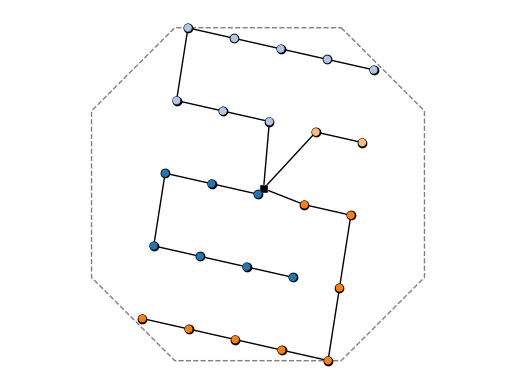

In [6]:
plot_layout(
    prob,
    input_dict=input_dict,
    show_image=True,
    include_cable_routing=True,
)
plt.show()

The result: a farm that fits in a stop-sign domain and minimzes the LCOE.